# Appliances Energy Consumption Time Series Analysis

In this notebook, we will analyze the energy consumption of appliances.<br>
The intention is to apply Time Series decomposition techniques found in the book *Forecasting: Principles and Practice, the Pythonic Way*, Chapter 4.

## Imports

In [1]:
# Packages installation
!pip install tsfeatures ucimlrepo --quiet

#Data manipulation
import pandas as pd
import numpy as np

# Dataviz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

#Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from tsfeatures import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 33.0 MB/s eta 0:00:00


## Load Data

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
appliances_energy_prediction = fetch_ucirepo(id=374)

# data (as pandas dataframes)
X = appliances_energy_prediction.data.features
y = appliances_energy_prediction.data.targets

In [58]:
# To Pandas DataFrame
df = pd.concat([X, y], axis=1)
df['date'] = df['date'].apply(lambda x: x[:10] + ' ' + x[10:])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Remove the first day and last days data, because it starts/ends at 17h instead of 0h
df = df["2016-01-12":"2016-05-26"]

df.tail(4)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
date,,,,,,,,,,,,,,,,,,,,,
2016-05-26 23:20:00,20,24.426667,44.53,23.318571,43.564286,26.70,38.760000,24.760000,43.260000,22.600000,...,44.5,15.5,756.1,77.0,3.666667,63.666667,11.4,17.240394,17.240394,60
2016-05-26 23:30:00,20,24.390000,44.56,23.254000,43.656000,26.70,38.963333,24.823333,43.326667,22.600000,...,44.5,15.3,756.1,77.5,3.500000,63.500000,11.3,49.420751,49.420751,70
2016-05-26 23:40:00,20,24.390000,44.56,23.225714,43.684286,26.76,39.090000,24.890000,43.400000,22.533333,...,44.5,15.1,756.1,78.0,3.333333,63.333333,11.2,0.948283,0.948283,70
2016-05-26 23:50:00,10,24.390000,44.56,23.200000,43.754000,26.73,39.230000,24.890000,43.363333,22.533333,...,44.5,15.0,756.1,78.5,3.166667,63.166667,11.2,3.884818,3.884818,60


## Transform Data

In [59]:
# Resample to hour
df = df.resample('h').sum()
df.index.freq = 'h'

# Add month, day and hour columns
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

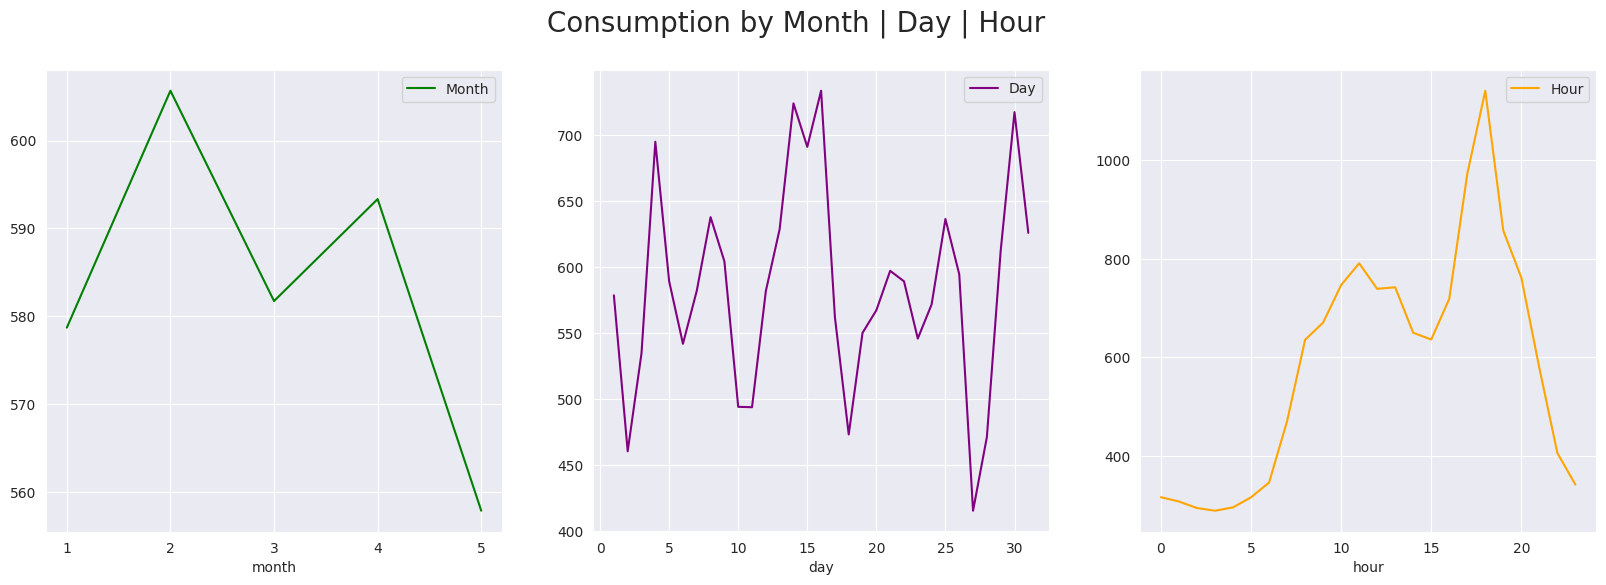

In [60]:
# Figure
plt.subplots(nrows=1, ncols=3,figsize=(20,6))
plt.suptitle('Consumption by Month | Day | Hour', fontsize=20)

# Appliances Consumption by Month
plt.subplot(1,3,1)
df.groupby('month')['Appliances'].mean().plot(color= 'green', label='Month', legend=True, xticks=[1,2,3,4,5]);

# Appliances Consumption by Day
plt.subplot(1,3,2)
df.groupby('day')['Appliances'].mean().plot(color='purple', label='Day', legend=True);

# Appliances Consumption by Hour
plt.subplot(1,3,3)
df.groupby('hour')['Appliances'].mean().plot(color='orange', label='Hour', legend=True);


In [61]:
# Create a copy of the DF
df2 = df.copy().reset_index()

In [62]:
df2 = (df2
       .melt(id_vars='date',
             value_name= 'y',
             var_name='unique_id',
             value_vars=df.columns)
       .rename(columns={'date':'ds'})
)

In [63]:
df2.head(4)

,ds,unique_id,y
0,2016-01-12 00:00:00,lights,100.0
1,2016-01-12 01:00:00,lights,50.0
2,2016-01-12 02:00:00,lights,0.0
3,2016-01-12 03:00:00,lights,0.0


## Auto-Correlation Analysis

We can use auto-correlation analysis in Time Series to know how much is the influence of the previous period in the continuity of the series. In simpler terms, it measures how much a value in a time series is related to its past values at different time intervals (lags).

In [64]:
# Calculate autocorrelation features
acf_feat = tsfeatures(df2.query("unique_id not in ('month', 'day', 'hour')"),
                      freq=24, features=[acf_features])
acf_feat

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Appliances,0.581357,0.716546,-0.357679,0.138501,-0.650505,0.464849,0.300977
1,Press_mm_hg,0.997774,9.240251,0.898935,2.718750,0.182854,0.112845,0.703636
2,RH_1,0.955474,7.448585,-0.036385,0.051504,-0.424694,0.197248,0.719193
3,RH_2,0.969327,5.443131,0.379520,0.235023,-0.249809,0.117304,0.709729
4,RH_3,0.981564,8.450544,0.057370,0.029491,-0.406939,0.181261,0.801751
5,RH_4,0.990957,8.873876,0.256860,0.083469,-0.258263,0.149621,0.796084
6,RH_5,0.794988,1.621330,0.034803,0.066695,-0.377500,0.170606,0.231348
7,RH_6,0.985658,6.863968,0.557701,0.581364,-0.160637,0.065318,0.877080
8,RH_7,0.990466,7.670012,0.585114,0.655864,-0.153109,0.080592,0.751680
9,RH_8,0.983544,6.203359,0.580374,0.726208,-0.146859,0.095531,0.764951


In [69]:
max_acf = acf_feat.loc[acf_feat["x_acf1"].idxmax()]['unique_id']
min_acf = acf_feat.loc[acf_feat["x_acf1"].idxmin()]['unique_id']

print(f"The most auto-correlated series is: {max_acf}")
print(f"The least auto-correlated series is: {min_acf}")

The most auto-correlated series is: T9
The least auto-correlated series is: rv1


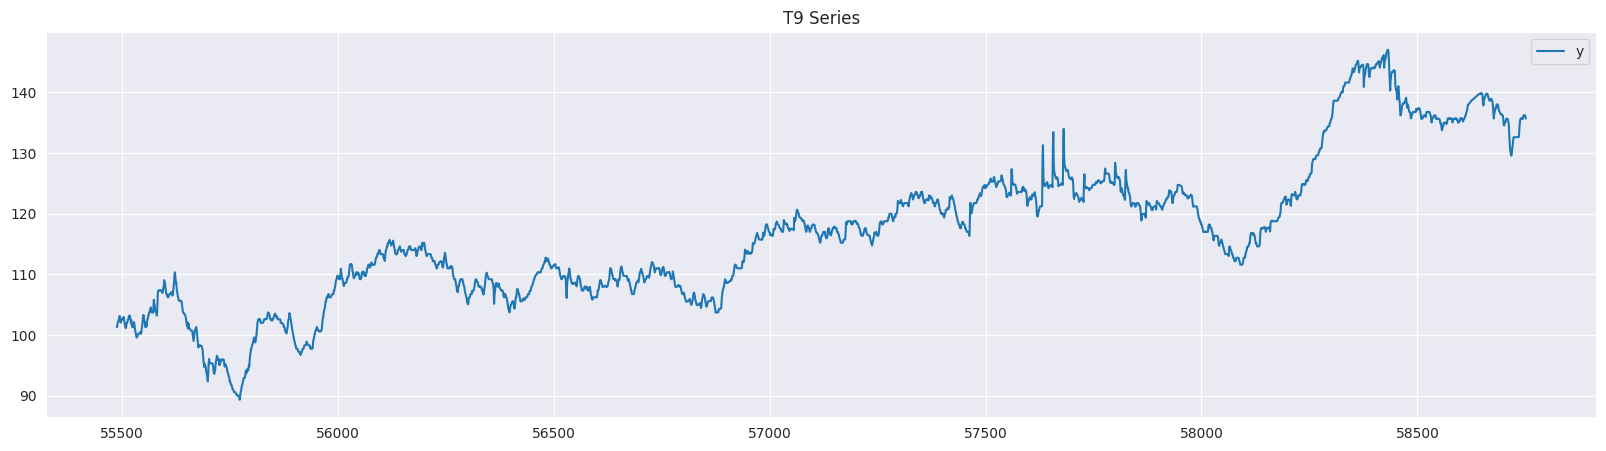

In [70]:
# Plotting the most auto-correlated series
df2.query('unique_id == @max_acf')['y'].plot(x='ds', y='y',
                                                figsize=(20, 5),
                                                legend=True, title= "T9 Series");

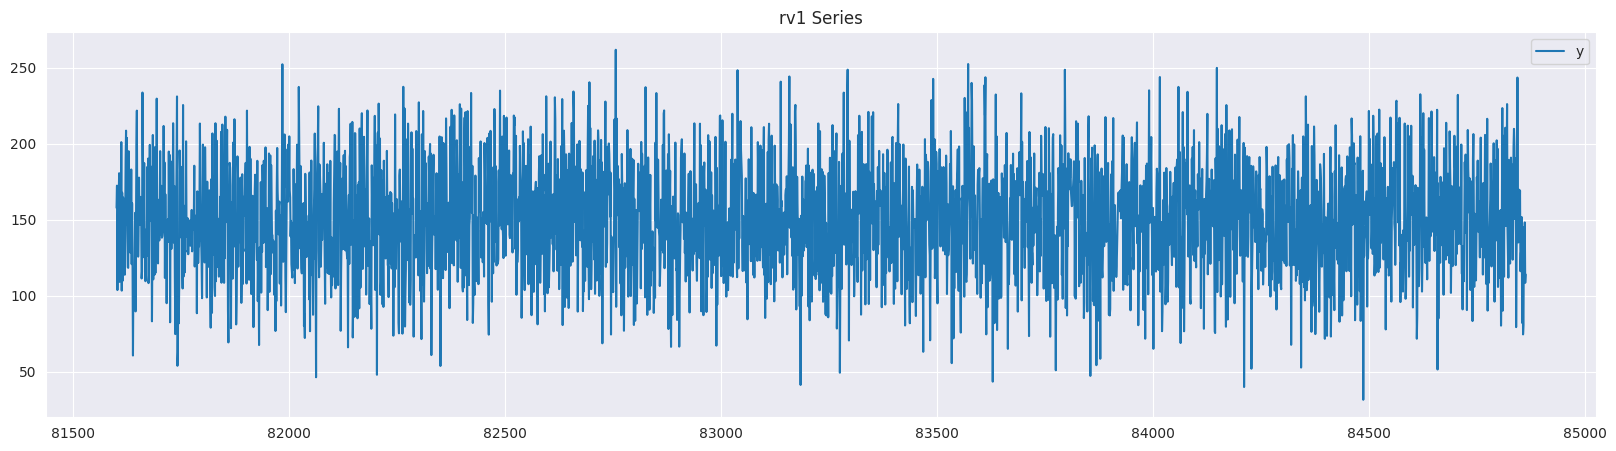

In [67]:
# Plotting the least auto-correlated series
df2.query('unique_id == @min_acf')['y'].plot(x='ds', y='y',
                                                figsize=(20, 5),
                                                legend=True, title= 'rv1 Series');

## STL Features Analysis

**Seasonal Trend w/ LOESS** is a decomposition mode for time series used to check trends and seasonalities to find patterns in time series

In [78]:
# STL decomposition
stl_feat = tsfeatures(df2.query("unique_id not in ('month', 'day', 'hour')"),
                      freq=24, features=[stl_features])
stl_feat

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Appliances,1,24,0.264058,1.619058e-07,-0.962676,0.506745,0.316260,0.314679,0.437951,17,4
1,Press_mm_hg,1,24,0.986380,1.280380e-10,-2.117457,4.602362,0.972342,3.435016,0.158697,1,15
2,RH_1,1,24,0.923069,4.462936e-09,-6.468430,21.022280,0.638268,0.702748,0.377728,20,18
3,RH_2,1,24,0.908650,3.091666e-09,-5.458092,6.558176,0.790234,1.237527,0.731701,8,12
4,RH_3,1,24,0.955820,9.970612e-10,-24.949839,24.580391,0.705942,0.933892,0.365457,21,18
5,RH_4,1,24,0.968283,3.704240e-10,-15.521051,24.550165,0.815256,1.331052,0.278322,11,17
6,RH_5,1,24,0.506919,1.133032e-07,-14.449376,7.864295,0.617930,0.650746,0.346941,22,18
7,RH_6,1,24,0.953740,4.519686e-10,-47.024957,4.044982,0.836789,1.549756,0.779109,7,16
8,RH_7,1,24,0.952659,5.048404e-10,-10.474425,24.548128,0.895129,1.978392,0.621246,7,17
9,RH_8,1,24,0.941592,5.576431e-10,-16.650542,23.318683,0.860736,1.721569,0.783174,3,17


In [72]:
# Example: Looking at the Appliances peak
df3 = df2.query('unique_id == "Appliances"').copy()
df3['hr'] = df3['ds'].dt.hour
df3.groupby('hr').y.mean().sort_values(ascending=False)

,y
hr,
18,1141.029412
17,971.985294
19,857.058824
11,790.955882
20,761.985294
10,746.691176
13,742.279412
12,739.117647
16,718.750000


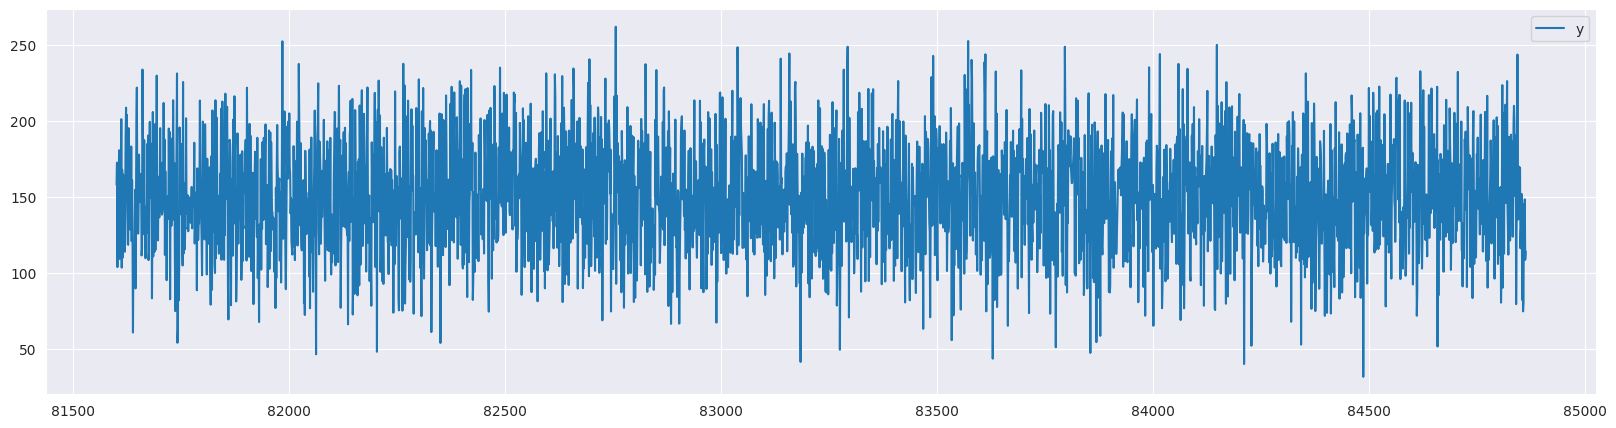

In [74]:
# Plotting the least linear series
df2.query('unique_id == "rv1"')['y'].plot(x='ds', y='y',
                                                figsize=(20, 5),
                                                legend=True);

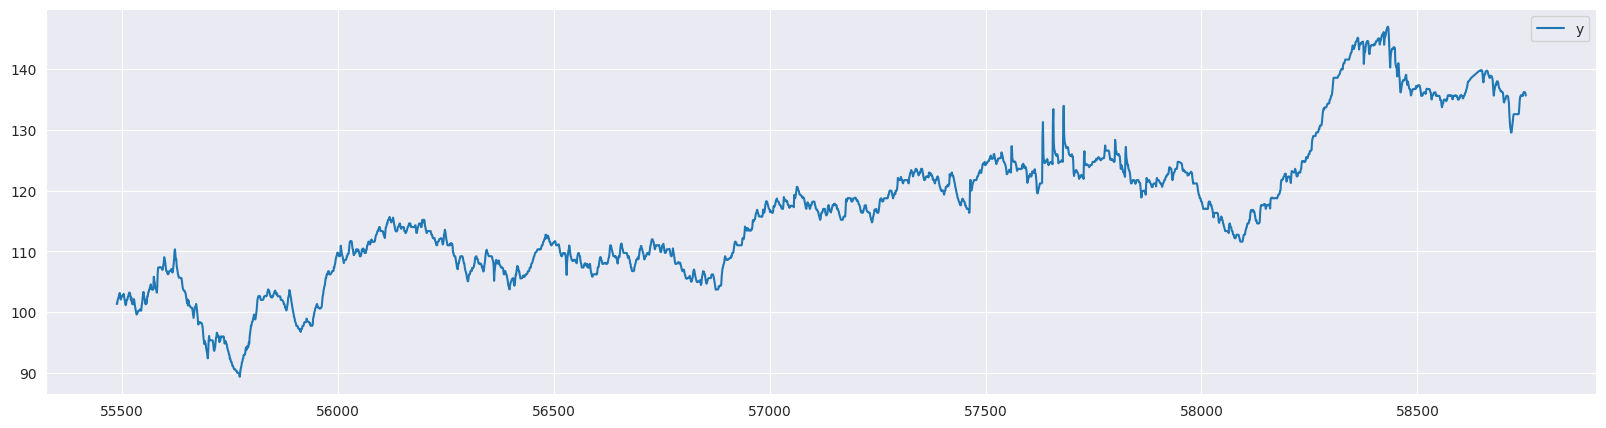

In [76]:
# Plotting the highest trend series
df2.query('unique_id == "T9"')['y'].plot(x='ds', y='y',
                                                figsize=(20, 5),
                                                legend=True);

In [95]:
# Redefining "unique_id" in groups
df3 = df2.copy()
df3['unique_id'] = np.select([df3.unique_id.str.contains('T'), df3.unique_id.str.contains('RH')],
                         ['Temperature', 'Humidity'], default= df3.unique_id)
df3 = df3.query('unique_id not in ("month","day","hour")')

In [96]:
# STL decomposition
stl_feat = tsfeatures(df3, freq=24, features=[stl_features])
stl_feat

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Appliances,1,24,0.264058,1.619058e-07,-0.962676,0.506745,0.316260,0.314679,0.437951,17,4
1,Humidity,1,24,0.960781,1.723990e-11,64.398797,41.564652,0.778130,1.224929,0.714795,7,16
2,Press_mm_hg,1,24,0.986380,1.280380e-10,-2.117457,4.602362,0.972342,3.435016,0.158697,1,15
3,Temperature,1,24,0.992687,5.258693e-13,-104.556731,-47.319096,0.859043,1.620717,0.786334,16,6
4,Visibility,1,24,0.272034,1.175307e-07,-6.296577,-1.347996,0.684740,0.754202,0.169823,9,7
5,Windspeed,1,24,0.826797,5.821572e-09,-14.379808,0.360767,0.804555,1.256492,0.413754,17,6
6,lights,1,24,0.338847,1.077693e-07,-11.874312,-0.736677,0.548175,0.565578,0.365014,21,3
7,rv1,1,24,0.060362,1.071904e-07,-0.012244,-0.628346,-0.009344,0.030480,0.157054,5,3
8,rv2,1,24,0.060362,1.071904e-07,-0.012244,-0.628346,-0.009344,0.030480,0.157054,5,3


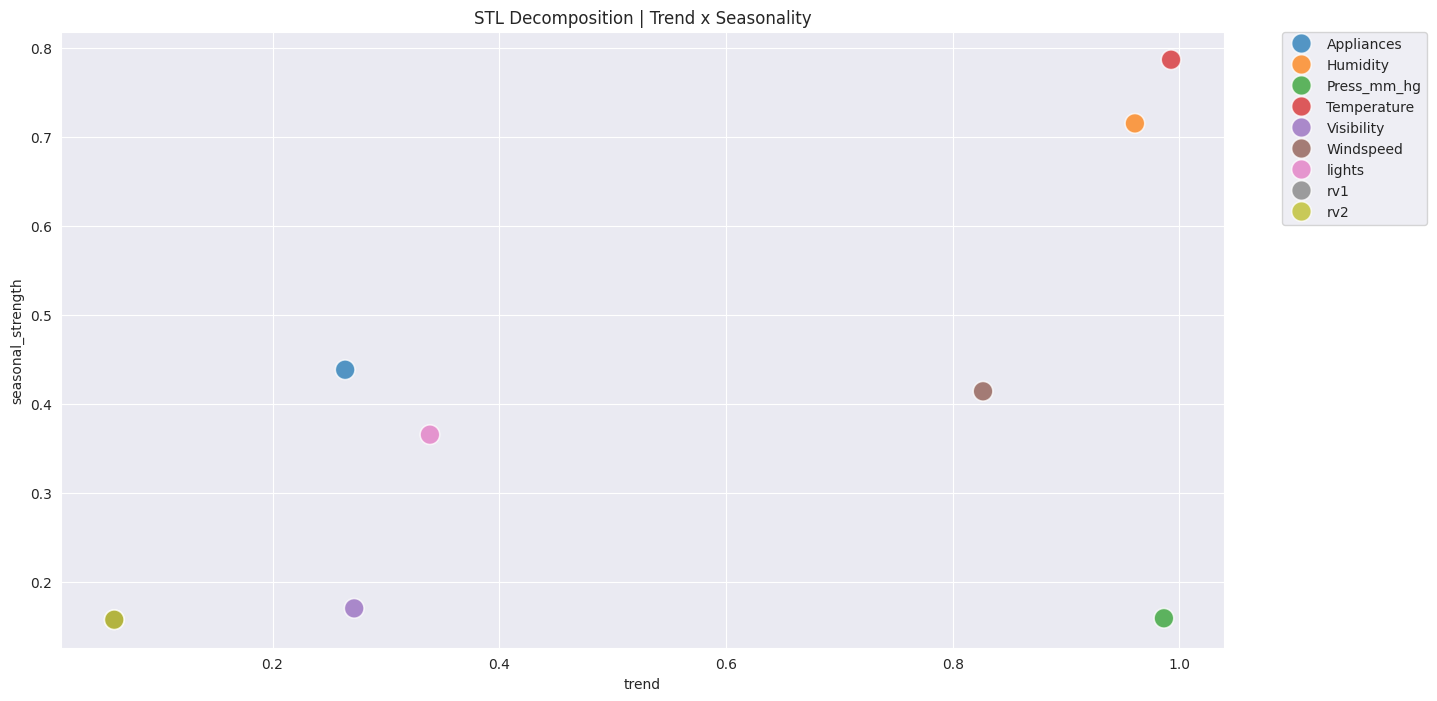

In [98]:
plt.figure(figsize=(15, 8))
sns.scatterplot(
    x=stl_feat['trend'],
    y=stl_feat['seasonal_strength'],
    hue=stl_feat['unique_id'],
    markers=stl_feat['unique_id'], s=200, alpha=0.75)

# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)
plt.title('STL Decomposition | Trend x Seasonality')
plt.show()

*Temperature, Humidity, and Pressure* are the series with most trend and seasonality, what makes sense because those change throughout the hours in the day and according to the month of the year.

*Lights*, on the other hand, won't have a very strong trend, as they are used similarly along the days, meaning when it's dark. It should change according with the hour of th day, though, and that is why the seasonality is higher than the trend.

*Appliances* shows a stronger seasonality than trend.

In [99]:
df4 = df2.query('unique_id not in ("rv1", "rv2", "month", "day", "hour")').copy()
df4['hr'] = df4['ds'].dt.hour
df4

,ds,unique_id,y,hr
0,2016-01-12 00:00:00,lights,100.0,0
1,2016-01-12 01:00:00,lights,50.0,1
2,2016-01-12 02:00:00,lights,0.0,2
3,2016-01-12 03:00:00,lights,0.0,3
4,2016-01-12 04:00:00,lights,0.0,4
...,...,...,...,...
91387,2016-05-26 19:00:00,Appliances,1340.0,19
91388,2016-05-26 20:00:00,Appliances,550.0,20
91389,2016-05-26 21:00:00,Appliances,460.0,21
91390,2016-05-26 22:00:00,Appliances,420.0,22


In [103]:
all_features = [acf_features, arch_stat, crossing_points, entropy, flat_spots,
                heterogeneity, holt_parameters, lumpiness, nonlinearity,
                pacf_features, stl_features, stability, hw_parameters,
                unitroot_kpss, unitroot_pp, series_length, hurst]

all_feat = tsfeatures(df4, freq=24, features=all_features)
all_feat

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Appliances,0.425062,3264,-1511.782542,0.040183,0.427520,0.000000,0.000000e+00,0.140338,1,...,0.780212,494,0.116918,0.581357,0.716546,-0.357679,0.138501,-0.650505,0.464849,0.300977
1,Press_mm_hg,0.756299,3264,-29.862482,0.390885,1.000000,1.000000,7.416747e-09,0.939839,1,...,0.455049,58,0.998786,0.997774,9.240251,0.898935,2.718750,0.182854,0.112845,0.703636
2,RH_1,0.892289,3264,-92.235780,2.236636,0.898292,0.000000,3.357843e-02,0.845132,1,...,0.502960,186,0.756512,0.955474,7.448585,-0.036385,0.051504,-0.424694,0.197248,0.719193
3,RH_2,0.755768,3264,-168.922966,0.948582,0.975476,0.000000,2.452353e-02,0.681865,1,...,0.532315,192,0.888832,0.969327,5.443131,0.379520,0.235023,-0.249809,0.117304,0.709729
4,RH_3,0.980695,3264,-47.624707,8.981668,0.984349,0.000000,1.543658e-02,0.903140,1,...,0.398408,162,0.885126,0.981564,8.450544,0.057370,0.029491,-0.406939,0.181261,0.801751
5,RH_4,0.937933,3264,-34.208819,4.792420,1.000000,0.000000,1.490045e-08,0.917496,1,...,0.404549,108,0.949106,0.990957,8.873876,0.256860,0.083469,-0.258263,0.149621,0.796084
6,RH_5,0.933806,3264,-629.626747,4.801425,1.000000,0.000000,1.354285e-08,0.298805,1,...,0.768566,236,0.379056,0.794988,1.621330,0.034803,0.066695,-0.377500,0.170606,0.231348
7,RH_6,1.130098,3264,-106.575065,25.721711,0.983375,0.000000,1.662516e-02,0.806804,1,...,0.323066,125,0.950330,0.985658,6.863968,0.557701,0.581364,-0.160637,0.065318,0.877080
8,RH_7,0.932336,3264,-80.006991,3.299179,1.000000,0.531150,8.380046e-09,0.827205,1,...,0.456729,108,0.973785,0.990466,7.670012,0.585114,0.655864,-0.153109,0.080592,0.751680
9,RH_8,0.968267,3264,-141.226495,5.372386,0.984141,0.000000,1.585890e-02,0.727492,1,...,0.452510,172,0.953315,0.983544,6.203359,0.580374,0.726208,-0.146859,0.095531,0.764951


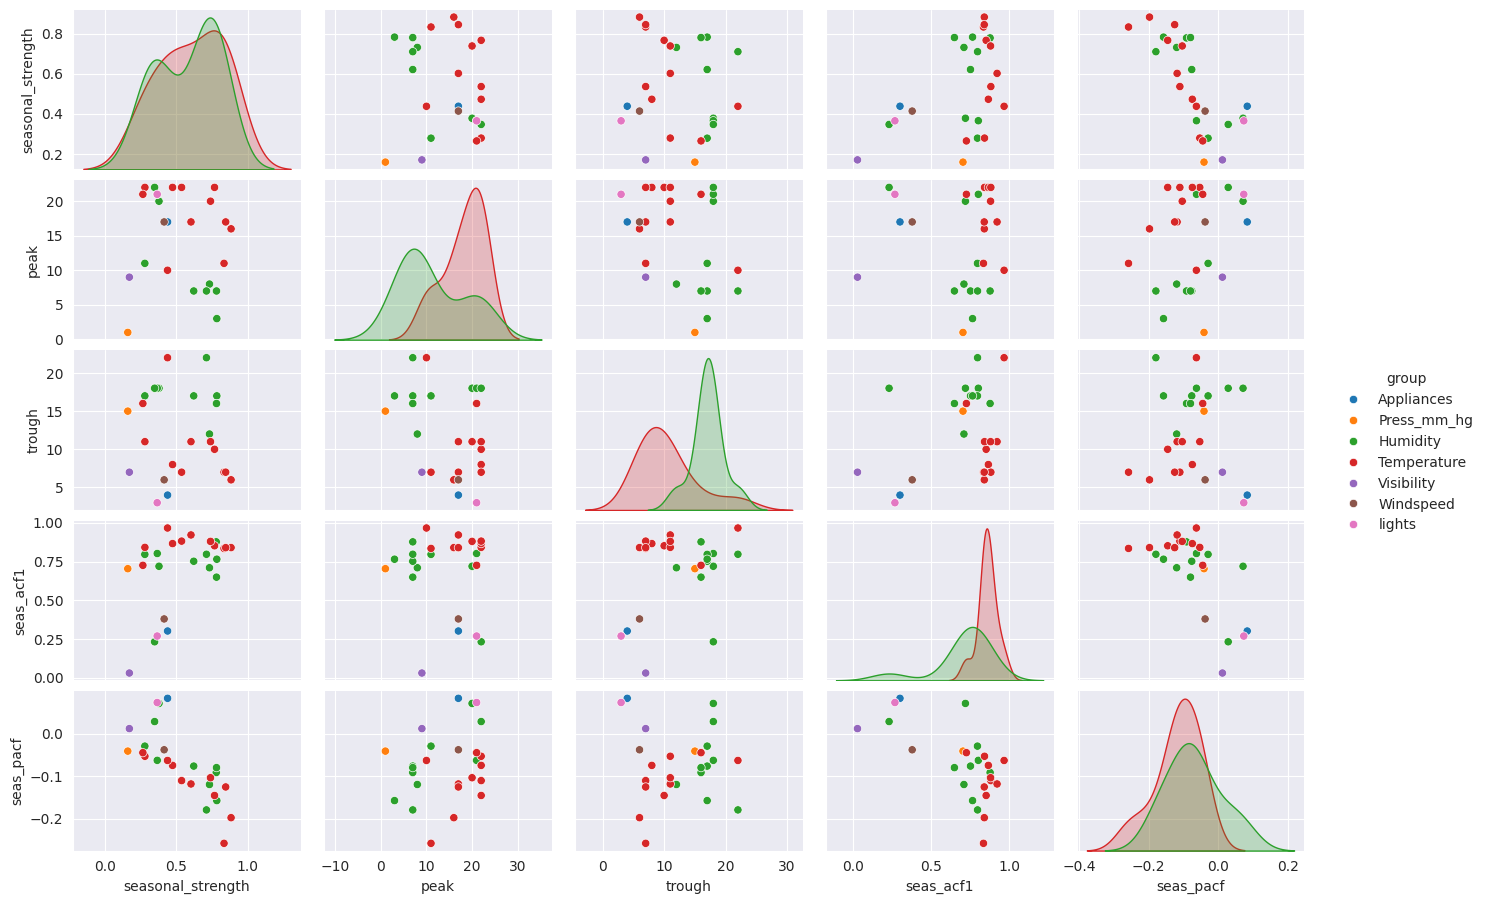

In [101]:
# Filter only some features
seasonal_feat = all_feat[
    ["unique_id", "seasonal_strength", "peak", "trough",
     "seas_acf1", "seas_pacf"]
]

# Add variable group
seasonal_feat['group']= np.select([seasonal_feat.unique_id.str.contains('T'), seasonal_feat.unique_id.str.contains('RH')],
                         ['Temperature', 'Humidity'], default= seasonal_feat.unique_id)

# Plot
g = sns.pairplot(seasonal_feat, hue="group")
g.fig.set_size_inches(15, 9)
plt.show()